# Simple time series model
### Using Naive Bayes for forecasting
This model takes advantage of one approach that is commonly known as binning (discretization or reducing the scale level of a random variable from numerical to categorical). An advantage of this technique is the reduction of noise - however, this comes at the cost of losing quite an amount of information.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from simple_time_series import *
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error

## Import and fix dataset

In [2]:
df = pd.read_csv('../../data/dataset.csv')
df.index = pd.to_datetime(df.pop('date'))
df = df.filter(['Canteen'])

Plot number of people vs time

Text(0.5, 1.0, 'Number of people at Telenor 2016-2019')

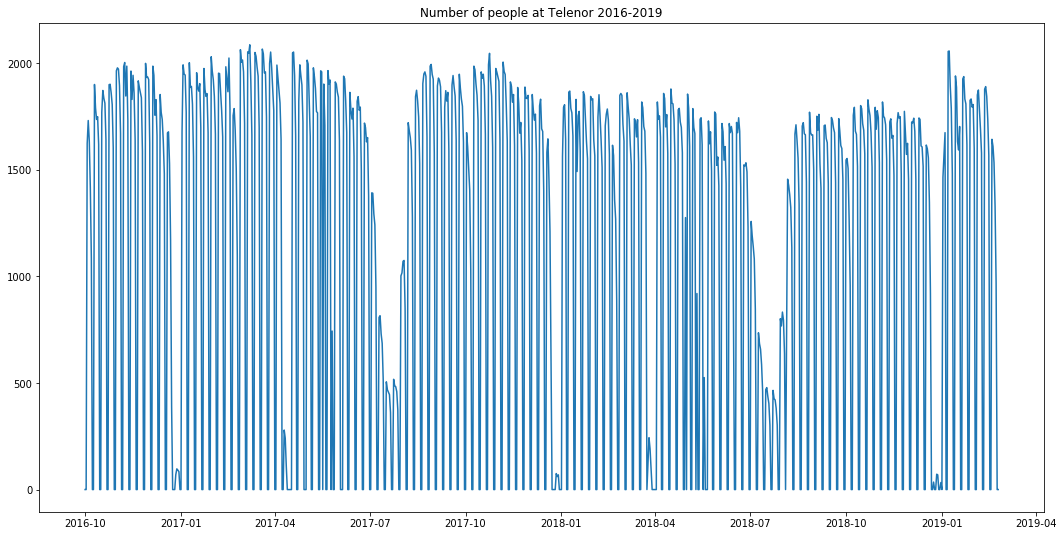

In [3]:
plt.figure(figsize=(18,9))
plt.plot(df)
plt.title('Number of people at Telenor 2016-2019')

Text(0.5, 1.0, 'Number of people at Telenor 2016-2019')

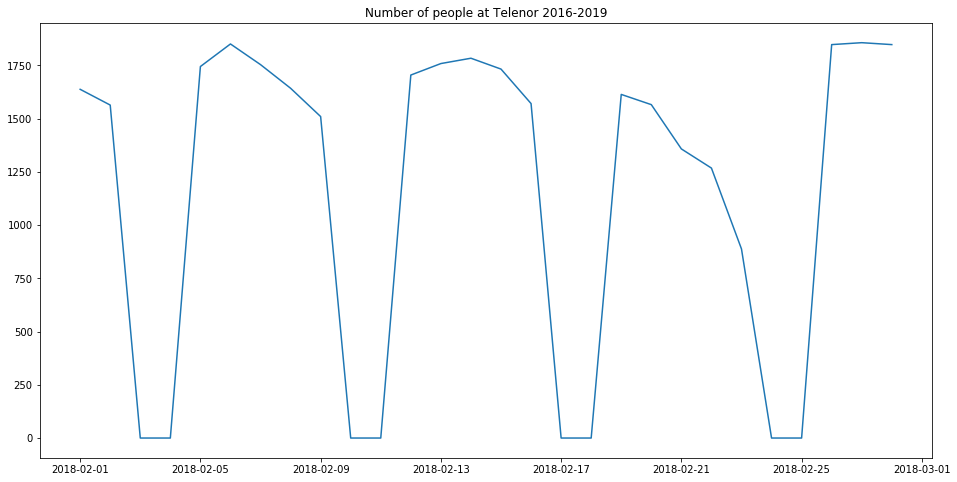

In [28]:
plt.figure(figsize=(16,8))
plt.plot(df['2018-02-01':'2018-02-28'])
plt.title('Number of people at Telenor 2016-2019')

In [ ]:
weekly = df.resample('B').sum()

In [ ]:
plt.figure(figsize=(18,9))
plt.plot(weekly)
plt.title('Number of people on business days')
#plt.style(style=[':', '---', '-'])

## Test for stationarity

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

- constant mean
- constant variance
- an autocovariance that does not depend on time.

### Moving average
We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant 't', we’ll take the average/variance of the last year, i.e. last 12 months. This is more of a visual technique.

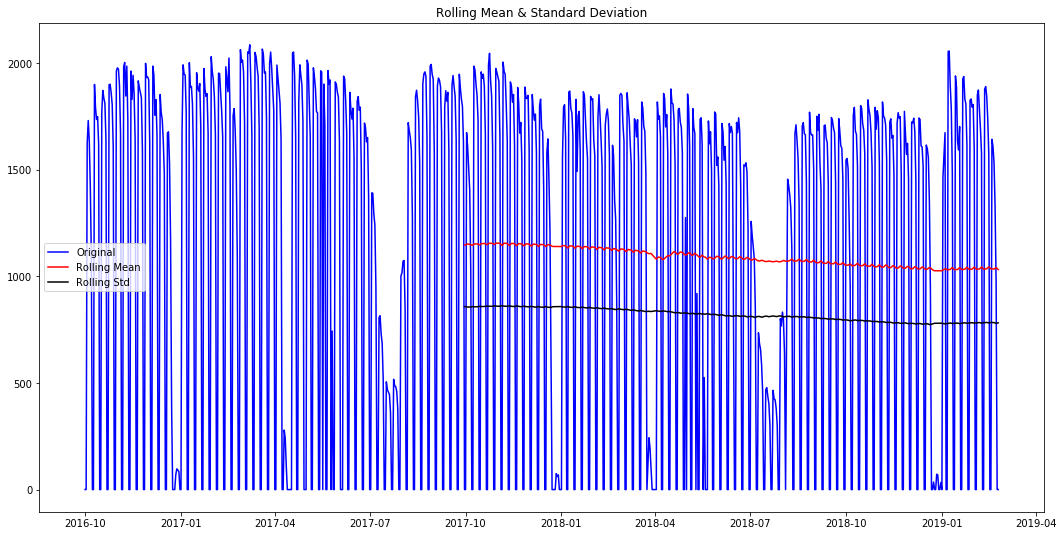

Results of Dickey-Fuller Test:
Test Statistic                  -5.365664
p-value                          0.000004
#Lags Used                      21.000000
Number of Observations Used    850.000000
Critical Value (1%)             -3.438067
Critical Value (5%)             -2.864946
Critical Value (10%)            -2.568584
dtype: float64


In [5]:
test_stationarity(df, 365)

Both the mean and standard deviation is slightly decreasing with time and this is therefore not a stationary series. Also, the test statistic is way smaller than the critical values. Note that the signed values should be compared and not the absolute values.

In [6]:
split = int(df.shape[0]/2)
x1 = df.iloc[:-split]
x2 = df.iloc[-split:]

mean1, mean2 = x1.mean(), x2.mean()
var1, var2 = x1.var(), x2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=1164.903670, mean2=1035.715925
variance1=730285.843573, variance2=619907.377827


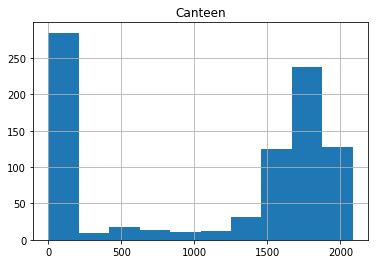

In [7]:
df.hist()
plt.show()

In [ ]:
moving_avg_diff = df - df.rolling(365).mean()
moving_avg_diff.dropna(inplace=True)
test_stationarity(moving_avg_diff)

## Split dataset

In [8]:
test_period = 8 # 20% of total

train = df.iloc[:-test_period]
test = df.iloc[-test_period:]

## Preprocessing

In [ ]:
trend_removed = train.diff()

In [ ]:
plt.figure(figsize=(18,9))
plt.plot(trend_removed)

In [ ]:
df2.std()

In [ ]:
from sklearn import preprocessing

x = df2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized = pd.DataFrame(x_scaled)

In [ ]:
diffs = normalized.diff()

## Binning the data
To bin the data,  K∈ℤ+  intervals on ℝ are being assigned. Now, each continuous observation xt is replaced by an indicator xt=k, k∈{1;...;K} where k is the interval that xt falls in. The number of intervals was chosen arbitrarily.

In [9]:
bins = [-1, 1, 200, 500, 1000, 1500, 1700, 1800, 1900, 10000] # Desired bins for people in canteen
# bins = [-1, 1, 100, 300, 500, 700, 1000, 1200, 1500, 1700, 1800, 1900, 10000]

The data are binned and the mean of realizations xt in each interval is saved in a dictionary in order to map the interval category back to actual realizations (bin_means).

In [10]:
binned_series, bin_means = bin_data(train, bins)
binned_test_series, bin_test_means = bin_data(test, bins)

In [11]:
binned_series.head()

date
2016-10-01    1
2016-10-02    1
2016-10-03    6
2016-10-04    7
2016-10-05    6
dtype: int64

In [12]:
bin_means

{1: Canteen    0.0
 dtype: float64, 2: Canteen    82.571429
 dtype: float64, 3: Canteen    401.304348
 dtype: float64, 4: Canteen    742.0
 dtype: float64, 5: Canteen    1328.127273
 dtype: float64, 6: Canteen    1618.863093
 dtype: float64, 7: Canteen    1749.700855
 dtype: float64, 8: Canteen    1850.514286
 dtype: float64, 9: Canteen    1967.105318
 dtype: float64}

To forecast future realizations, the classic approach of using  S∈ℤ+  lagged realizations of  xt  will be applied. The amount of lags I chose was  365, assuming that there is no longer auto-dependency of the process beyond a horizon of one year.

In [13]:
train_x, train_y = get_lagged_list(binned_series, test_period)

In [14]:
train_x.head()

,1,2,3,4,5,6,7
date,,,,,,,
2016-10-08,5.0,5.0,6.0,7.0,6.0,1.0,1.0
2016-10-09,1.0,5.0,5.0,6.0,7.0,6.0,1.0
2016-10-10,1.0,1.0,5.0,5.0,6.0,7.0,6.0
2016-10-11,8.0,1.0,1.0,5.0,5.0,6.0,7.0
2016-10-12,7.0,8.0,1.0,1.0,5.0,5.0,6.0


In [15]:
train_y.head()

date
2016-10-08    1
2016-10-09    1
2016-10-10    8
2016-10-11    7
2016-10-12    7
Name: 0, dtype: int64

## Predictive Model

In [16]:
model = create_model(train_x, train_y)

To calculate the 'class'-means from before, I wrote a quick function that takes the predicted class as an input and returns the corresponding means.

In [17]:
resulting_prediction = find_training_prediction(train_x, train_y, model, bin_means)

### Plot training prediction

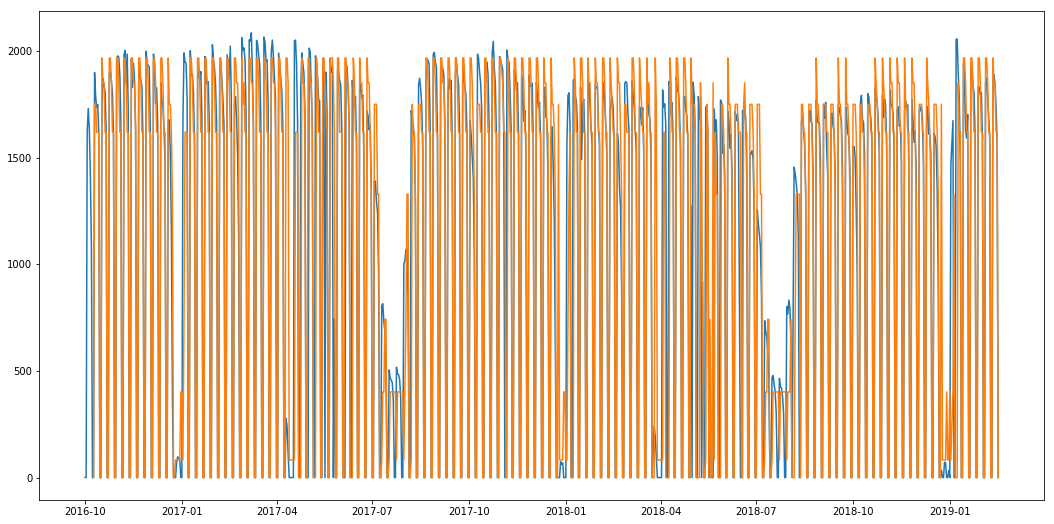

In [18]:
plt.figure(figsize = (18,9))
plt.plot(train)
plt.plot(resulting_prediction)

### Finding predictions for test set (out of samle forecast)

Out-of-sample forecasts need to be calculated iteratively since lagged values are required.

In [19]:
predictions, pred_class = find_prediction_forecast(test, train_x, train_y, model, bin_means)

# Results

### Plotting prediction of test set

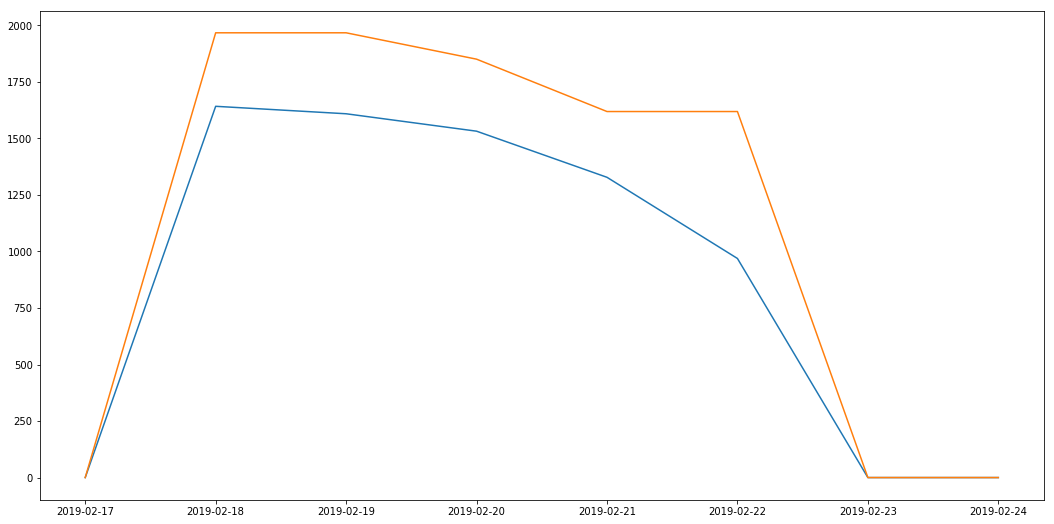

In [20]:
plt.figure(figsize = (18,9))
plt.plot(test)
plt.plot(predictions)

### Plotting both train and test prediction

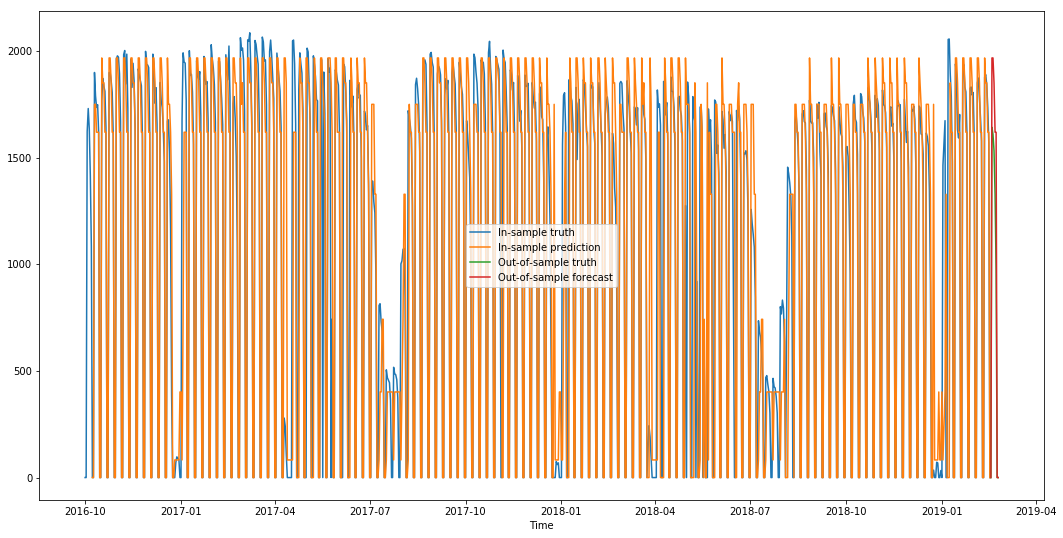

In [21]:
plt.figure(figsize = (18,9))
plt.plot(train)
plt.plot(resulting_prediction)

plt.plot(test)
plt.plot(predictions)
plt.xlabel("Time")
plt.legend(["In-sample truth", "In-sample prediction", "Out-of-sample truth", "Out-of-sample forecast"])

## RMSE and accuracy

### Testing accuracy

In [22]:
accuracy = test_accuracy(pred_class, binned_test_series)
print('The accuracy is ' + str(accuracy) + ' %')

The accuracy is 37.5 %


### RMSE and MAE

RMSE for test data and prediction:

In [23]:
find_RMSE(test, predictions)

324.481820330009

In [24]:
mae = mean_absolute_error(test, predictions)
mae

242.80638823431664

RMSE for training data and prediction:

In [25]:
find_RMSE(train, resulting_prediction)

417.5713906411252

In [26]:
mae_train = mean_absolute_error(train, resulting_prediction)
mae_train

ValueError: Found input variables with inconsistent numbers of samples: [864, 857]